In [1]:
from SonicBatt import utils
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1.inset_locator import (InsetPosition, mark_inset)
from matplotlib.ticker import FormatStrFormatter

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'degradation')
data_path = os.path.join(study_path, 'Raw Data')
visualistion_path = os.path.join(study_path, 'Visualisation')
database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
degr_tests = database.loc[database['test_type']=='degradation_exp1'].reset_index(drop=True)
degr_tests_cycling = database.loc[database['test_type']=='degradation_cycling_exp1'].reset_index(drop=True)

cycles_completed = [int(i) for i in degr_tests['cycles_completed'].to_list()]
days_elapsed = degr_tests['days_elapsed'].to_list()
cycles_and_days = []
for i in range(len(cycles_completed)):
    cycles_and_days.append(
        '{} (day {})'.format(int(cycles_completed[i]), int(days_elapsed[i]))
        )

def colorscheme(n_increments, cmap='Blues'):
    return iter(
        mpl.colormaps[cmap](np.linspace(0.2, 1, n_increments))
    )

temp_colorsheme = ListedColormap(cm.Reds(np.linspace(0.2, 1, 256)))

# Plot font settings
ticksize=8
mpl.rc('xtick', labelsize=ticksize)
mpl.rc('ytick', labelsize=ticksize)
mpl.rc('axes', titlesize=12, labelsize=10) # --> labelsize also acts on colorbar label.
mpl.rc('legend', fontsize=8, title_fontsize=10)
mpl.rc('lines', linewidth=0.8, markersize=1)


In [2]:
# Put EIS data in dictionaries
eis_keys = [4.2, 4.0, 3.8]
eis_dfs = {4.2: [], 4.0: [], 3.8: []}
eis_temperatures = {4.2: [], 4.0: [], 3.8: []}
eis_pre_ocvs = {4.2: [], 4.0: [], 3.8: []}

for i in range(len(degr_tests)):
    test_id = degr_tests['test_id'].iloc[i]
    test_dir = os.path.join(data_path, test_id)
    Protocol_objects = utils.create_custom_object(test_id, test_dir)
    #
    for j in range(len(eis_keys)):
        key = eis_keys[j]
        eis_dfs[key].append(Protocol_objects.EIS_other_seq.EIS_list[j].eis_df)
        previous_ind = Protocol_objects.EIS_other_seq.EIS_list[j].previous_ind
        # Obtain temperature at 'previous_ind' from cycling data array
        parquet_filename = '{}_cycling.parquet'.format(test_id)
        parquet_filepath = os.path.join(data_path, test_id,parquet_filename)
        df_cycling = pq.read_table(parquet_filepath).to_pandas()
        eis_temperatures[key].append(
            df_cycling.loc[previous_ind, 'Temp(degC)'])
        eis_pre_ocvs[key].append(
            df_cycling.loc[previous_ind, 'V(V)'])


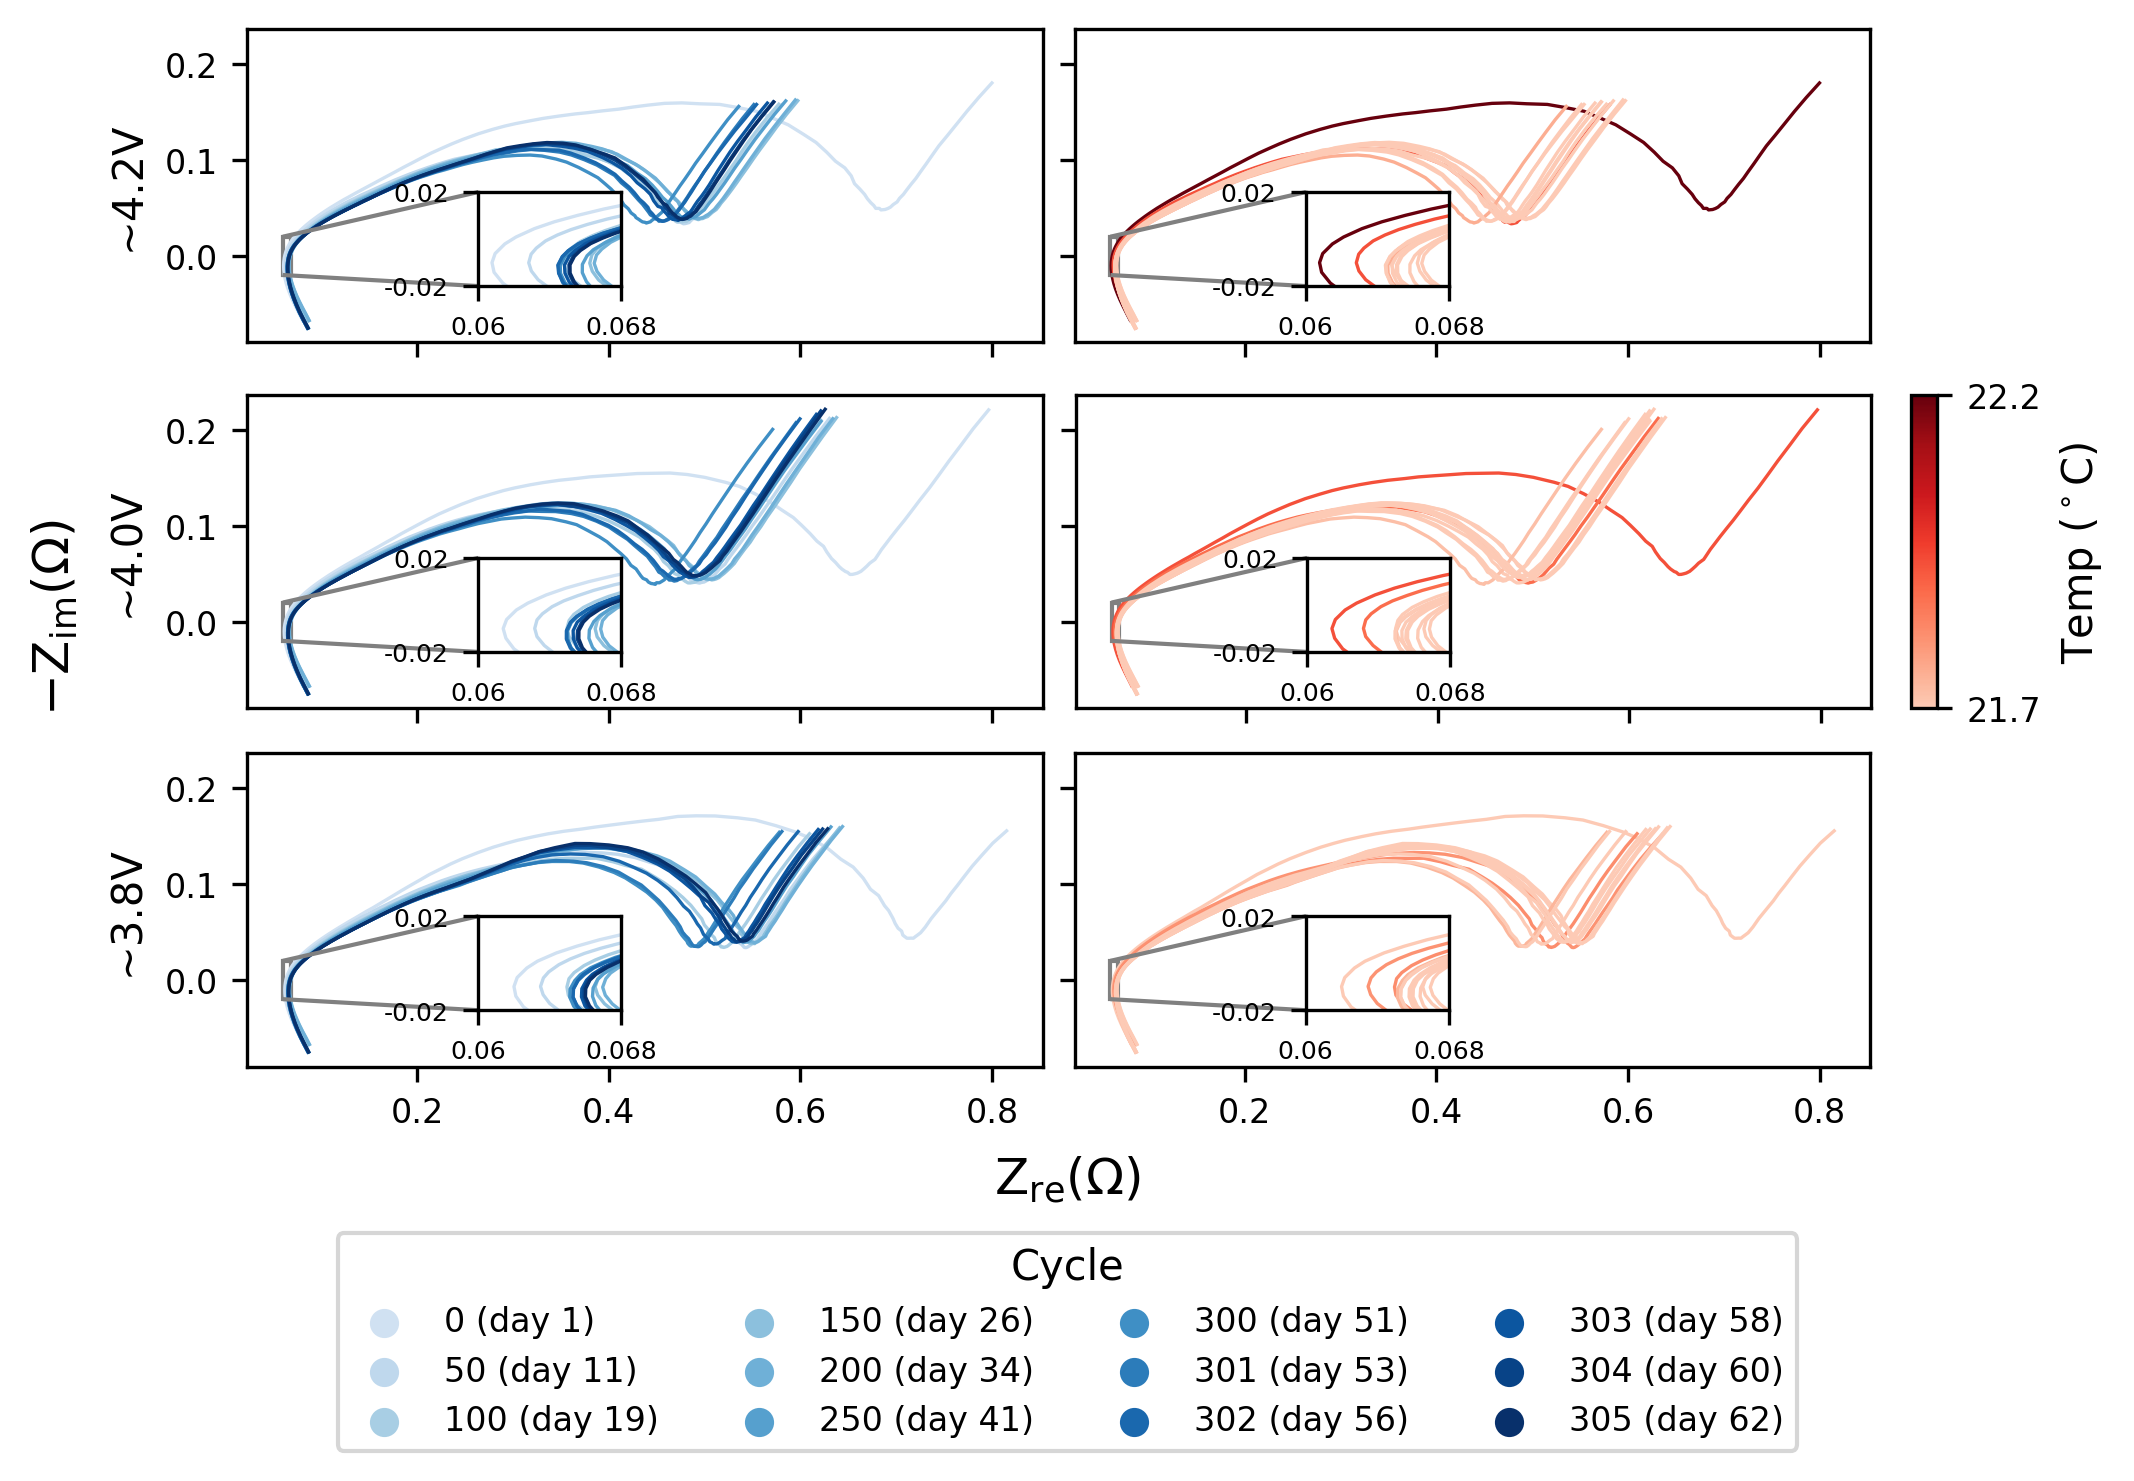

In [3]:
# Nyquist plots coloured by cycle and temperature
f, axs = plt.subplots(3, 2, figsize=(7,4), dpi=300,
                sharex=True, sharey=True, constrained_layout=True)
f.patch.set_facecolor('white')
ylabels = ['~4.2V', '~4.0V', '~3.8V']

axins = [plt.axes([0,0,1,1]) for _ in range(3)]
axins2 = [plt.axes([0,0,1,1]) for _ in range(3)]

for j, key in enumerate(eis_keys):
    color = colorscheme(len(degr_tests))
    for i, df_eis in enumerate(eis_dfs[key]):
        c = next(color)
        x = df_eis.loc[:, 'Zreal'].to_numpy()
        y = -df_eis.loc[:, 'Zimag'].to_numpy()
        if j == 0:
            label = cycles_and_days[i]
        else:
            label=None
        axs[j, 0].plot(x,y, c=c)
        axs[j, 0].scatter([],[],color=c, label=label)
        axins[j].plot(x,y, c=c)

    # Make sure x and y scales are equal
    axs[j,0].set_aspect('equal', adjustable='box')
    axs[j,0].set_ylabel(ylabels[j])

# Put a legend below current axis
f.legend(loc='upper center', bbox_to_anchor=(0.5, -0.0), title="Cycle",
          ncol=4, markerscale=6)

max_temp = max(eis_temperatures.values())[0]
min_temp = min(eis_temperatures.values())[0]
norm = mpl.colors.Normalize(
    vmin = min_temp,
    vmax = max_temp)
for j, key in enumerate(eis_keys):
    color = colorscheme(len(degr_tests))
    for i, df_eis in enumerate(eis_dfs[key]):
        temperature = eis_temperatures[key][i]
        c = temp_colorsheme(norm(temperature))
        x = df_eis.loc[:, 'Zreal'].to_numpy()
        y = -df_eis.loc[:, 'Zimag'].to_numpy()
        if j == 0:
            label = cycles_and_days[i]
        else:
            label=None
        axs[j,1].plot(x,y, c=c, label=label)
        axins2[j].plot(x,y, c=c)

    # Make sure x and y scales are equal
    axs[j,1].set_aspect('equal', adjustable='box')

# Position insets
for i in range(3):
    for j, axin in enumerate([axins, axins2]):
        ip = InsetPosition(axs[i,j], [0.29,0.18,0.18,0.3])
        axin[i].set_axes_locator(ip)
        mark_inset(axs[i,j], axin[i], loc1=2, loc2=3, fc="none", ec='0.5')
        # sub region of the original image
        x1, x2, y1, y2 = 0.060, 0.068, -0.02, 0.02
        axin[i].set_xlim(x1, x2)
        axin[i].set_ylim(y1, y2)
        # Needed for the next line to work (something about Fixed locators)
        axin[i].set_xticks([0.060, 0.068])
        axin[i].set_xticklabels([0.060, 0.068], fontsize=6)
        # Needed for the next line to work (something about Fixed locators)
        axin[i].set_yticks([-0.02, 0.02])
        axin[i].set_yticklabels([-0.02, 0.02], fontsize=6)

cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=temp_colorsheme), ax =axs[1,1],
            location='right', aspect=12, ticks=[min_temp, max_temp],
              format = FormatStrFormatter("%.1f"))
cb.set_label(label='Temp ($^\circ$C)')

f.supxlabel('$\mathrm{Z_{re} (\Omega)}$')
f.supylabel('$\mathrm{-Z_{im} (\Omega)}$')
f.align_ylabels()

save_filename = 'Exp1_eis'
utils.save_figure(f, visualistion_path, save_filename, 'png')


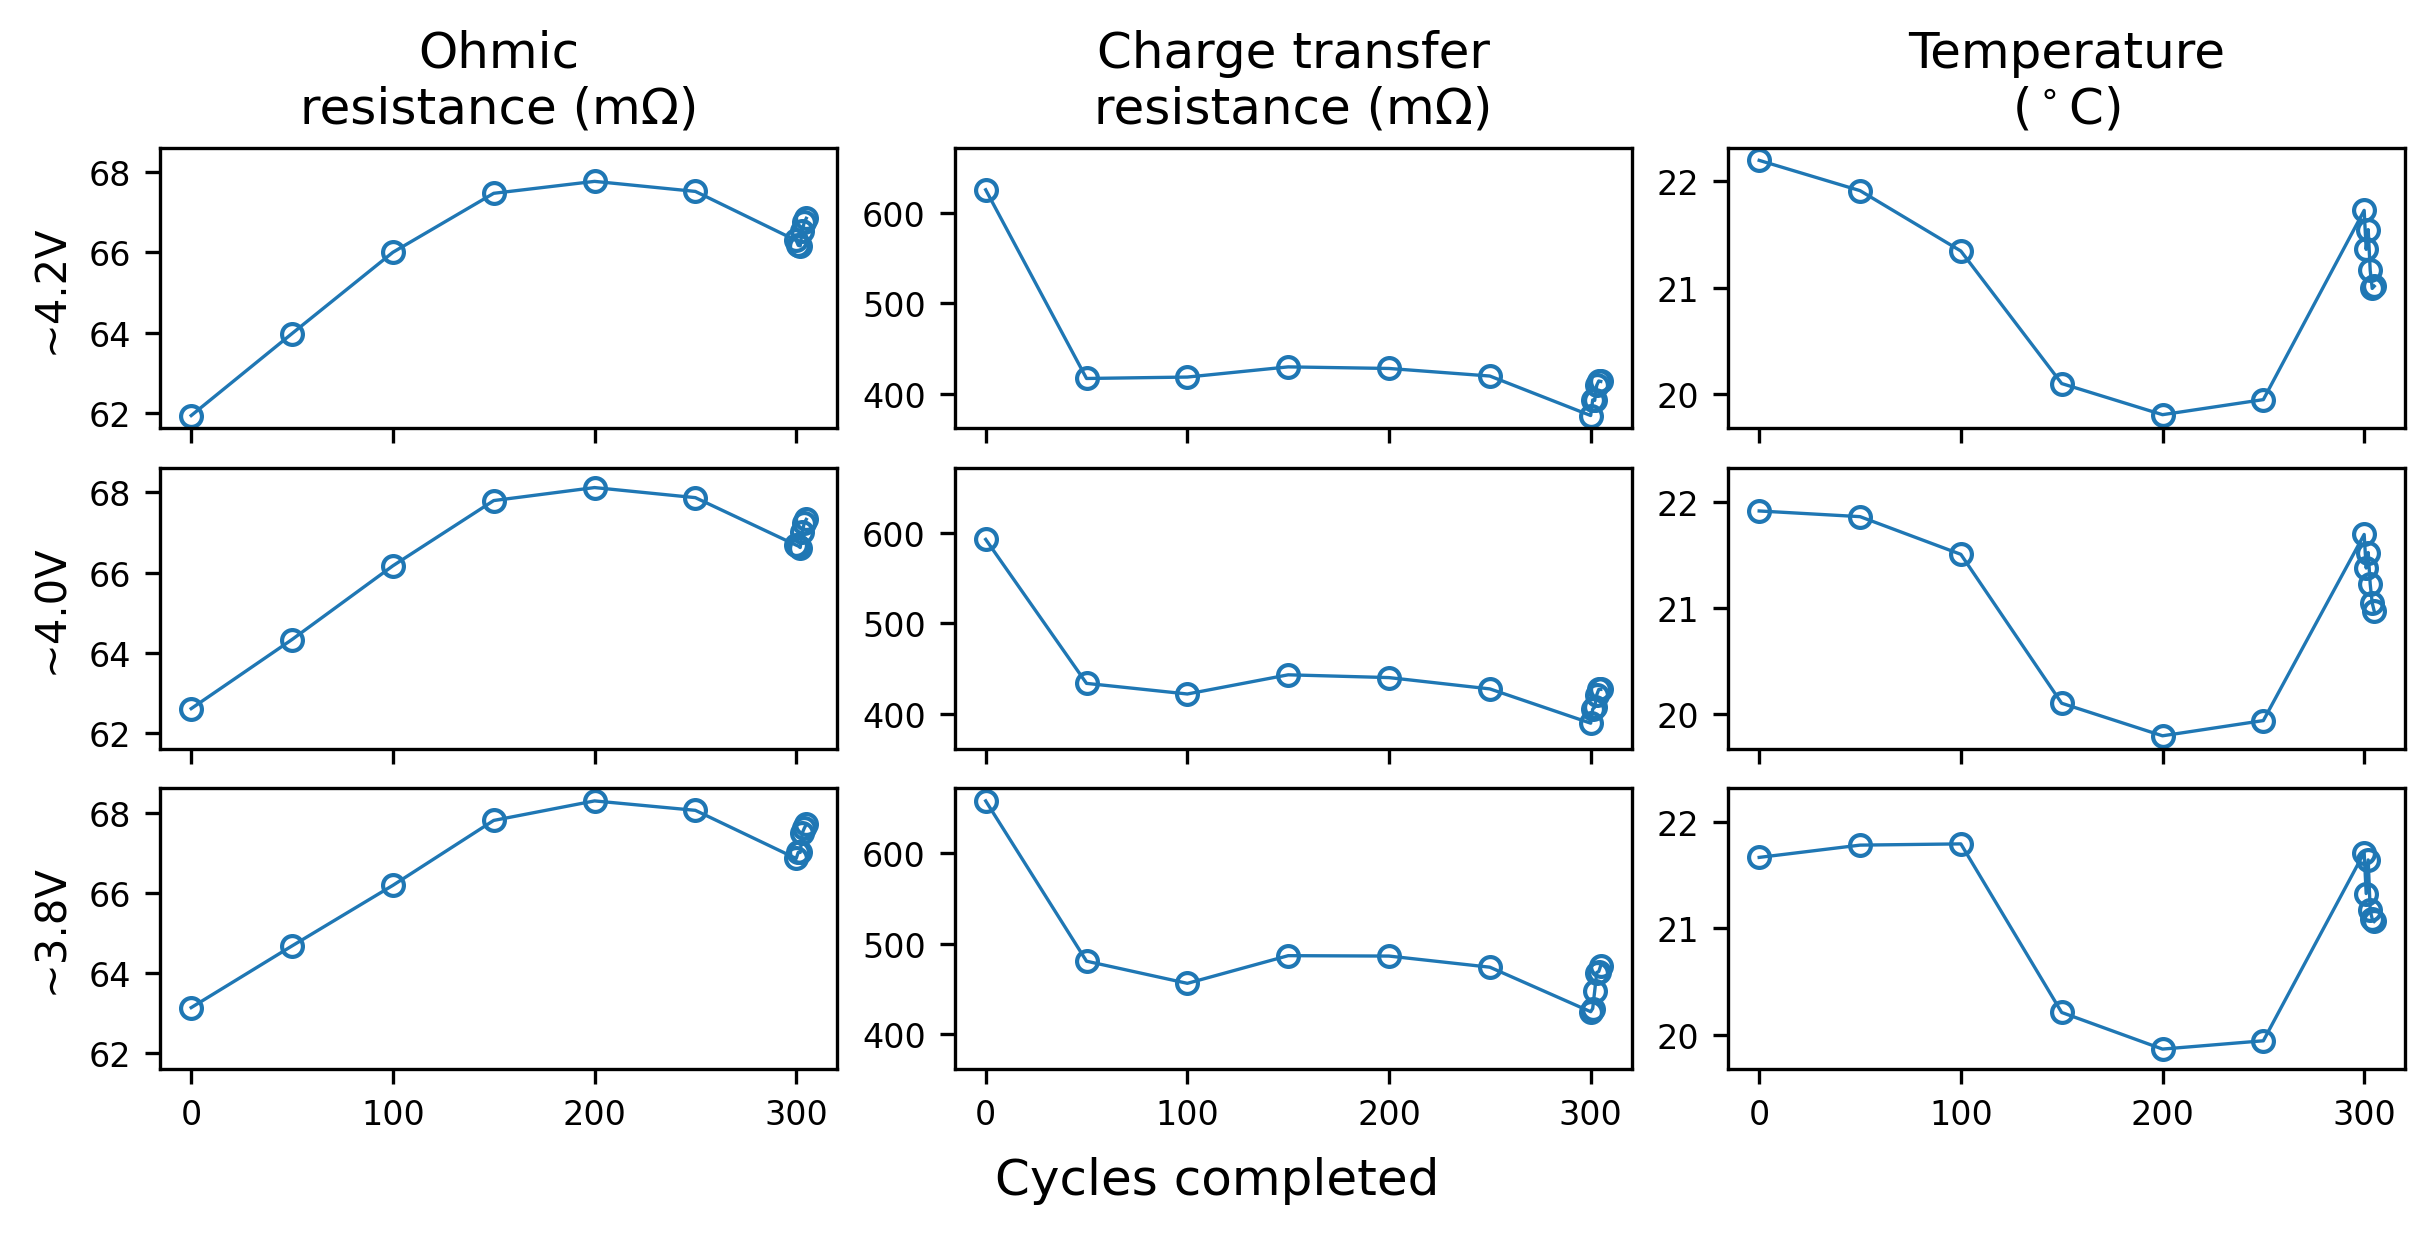

In [4]:
ohmic_impedances = {4.2: [], 4.0: [], 3.8: []}
Re_local_min = {4.2: [], 4.0: [], 3.8: []}
ct_impedances = {4.2: [], 4.0: [], 3.8: []}
ocvs = ['~4.2V', '~4.0V', '~3.8V']

for j, key in enumerate(eis_keys):
    for i, df_eis in enumerate(eis_dfs[key]):
        x = df_eis.loc[:, 'Zreal'].to_numpy()
        y = -df_eis.loc[:, 'Zimag'].to_numpy()
        ohmic_impedances[key].append(np.interp(0,y,x))
        #
        y_derivative= np.diff(y)
        y_derivative_reversed = y_derivative[::-1]
        for j, _ in enumerate(y_derivative_reversed):
            if ((y_derivative_reversed[j]>0) & (y_derivative_reversed[j+1]<0)):
                ind = len(y)-(j+1)
                Re_local_min[key].append((x[ind] + x[ind+1])/2)
                break
    ohmic_impedances[key] = np.array(ohmic_impedances[key])
    Re_local_min[key] = np.array(Re_local_min[key])
    ct_impedances[key] = Re_local_min[key] - ohmic_impedances[key]

s=5
f, axs = plt.subplots(3, 3, figsize=(8,4), dpi=300, sharex=True, sharey='col', constrained_layout=True)
for j, key in enumerate(eis_keys):
    axs[j,0].plot(cycles_completed, ohmic_impedances[key]*1000, color='tab:blue', marker='o', markersize=s, markerfacecolor='none')
    axs[j,1].plot(cycles_completed, ct_impedances[key]*1000, color='tab:blue', marker='o', markersize=s, markerfacecolor='none')
    axs[j,2].plot(cycles_completed, eis_temperatures[key], color='tab:blue', marker='o', markersize=s, markerfacecolor='none')
    axs[j,0].set_ylabel(ocvs[j])
axs[0,0].set_title('Ohmic\nresistance (mΩ)', fontsize=12)
axs[0,1].set_title('Charge transfer\nresistance (mΩ)', fontsize=12)
axs[0,2].set_title('Temperature\n($^\circ$C)', fontsize=12)
f.supxlabel('Cycles completed')

save_filename = 'Exp1_eis_decomposition'
utils.save_figure(f, visualistion_path, save_filename, 'pdf')


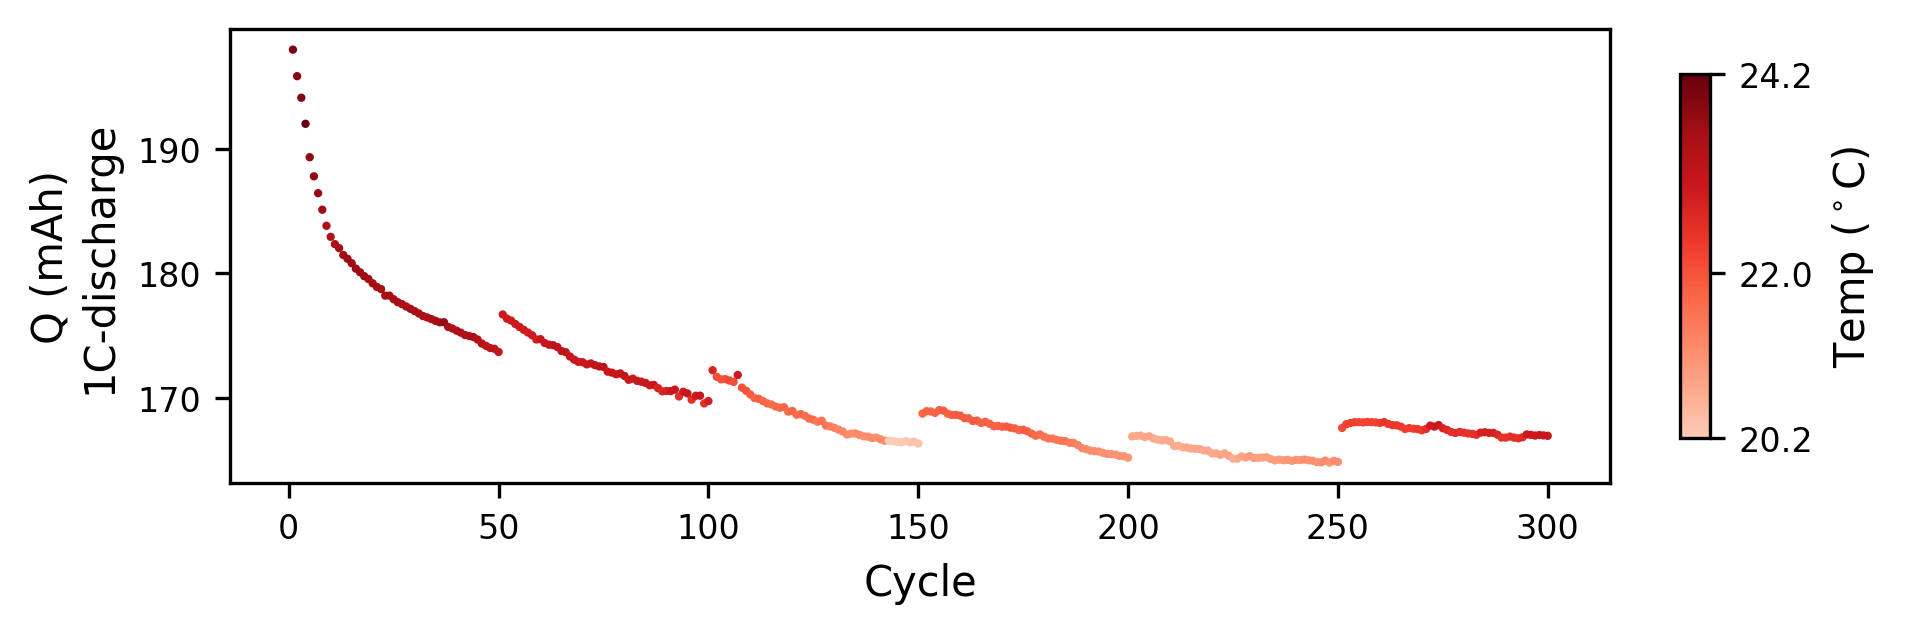

In [5]:
# Capacity fade
capacities_1c = []
temperatures_1c = []
cycles = []
for i in range(len(degr_tests_cycling)):
    test_id = degr_tests_cycling['test_id'].iloc[i]
    cycles_starting = degr_tests_cycling['cycles_completed'].iloc[i]
    
    test_dir = os.path.join(data_path, test_id)
    parquet_filename = '{}_cycling.parquet'.format(test_id)
    parquet_filepath = os.path.join(data_path, test_id,parquet_filename)
    df_cycling = pq.read_table(parquet_filepath).to_pandas()
    
    filter1 = df_cycling['I(A)'] < 0
    df_cycling.loc[filter1, 'Polarisation'] = '-'
    filter2 = df_cycling['Cycle'] != 999
    df_cycling.loc[filter2, 'Polarisation'] = '0'
    max_cycle = df_cycling.loc[filter1, 'Cycle'].max()
    count = 1
    for cycle in range(1, max_cycle+1):
        filter3 = df_cycling['Cycle'] == cycle
        temp_df = df_cycling.loc[filter1 & filter3]
        capacities_1c.append(
            temp_df.loc[:, 'Q(mAh)'].max() - temp_df.loc[:, 'Q(mAh)'].min())
        temperatures_1c.append(
            temp_df.loc[:, 'Temp(degC)'].mean()
        )
        cycles.append(cycles_starting + count)
        count += 1

norm = mpl.colors.Normalize(
    vmin=min(temperatures_1c), vmax=max(temperatures_1c))
c = temp_colorsheme(norm(temperatures_1c))
f, ax = plt.subplots(1,1, figsize=(6.25,2), dpi=300, constrained_layout=True)
ax.scatter(cycles, capacities_1c, c=c, s=1)
ax.set_xlabel('Cycle')
ax.set_ylabel('Q (mAh)\n1C-discharge')
cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=temp_colorsheme), ax =ax, 
            location='right', aspect=12, shrink=0.8,
            ticks=[min(temperatures_1c), 22, max(temperatures_1c)],
            format = FormatStrFormatter("%.1f"))
cb.set_label(label='Temp ($^\circ$C)')

save_filename = 'Exp1_Qfade'
utils.save_figure(f, visualistion_path, save_filename, 'png')
